In [72]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import price_new
import numpy as np
from scipy.special import comb

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single WindPowerForecast Model

In [2]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-10] +i/(365.0*24.0) for i in range(4)]#
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
rnd = np.random.normal(size=wind_onshore.rnd_shape(n_sims, timegrid.shape[0]))
results = wind_onshore.simulate(timegrid, rnd, 
                                       expiries=forward_expiries, 
                                       initial_forecasts=[0.8, 0.7,0.6,0.5])


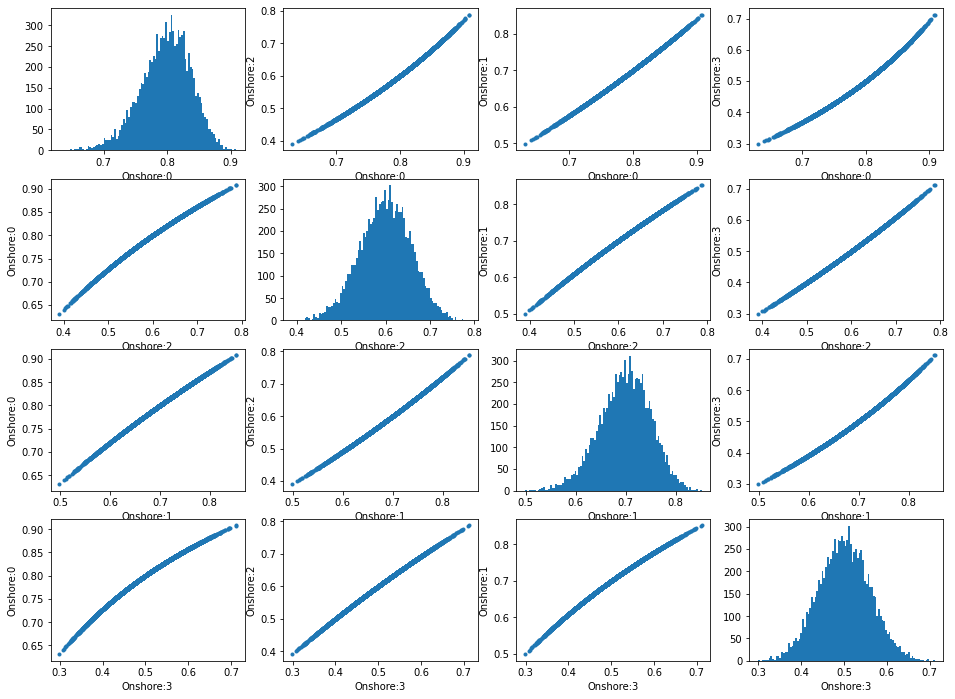

In [3]:
timepoint = -1
plt.figure(figsize=(16,12))
i=1
for k in results.keys():
    f1 = results.get(k)
    for l in results.keys():
        plt.subplot(4,4,i)
        f2 = results.get(l)
        if k==l:
            plt.hist(f1[timepoint], bins=100, label=k)
            plt.xlabel(k)
        else:
            plt.plot(f1[timepoint], f2[timepoint], '.')
            plt.xlabel(k)
            plt.ylabel(l)
        i += 1


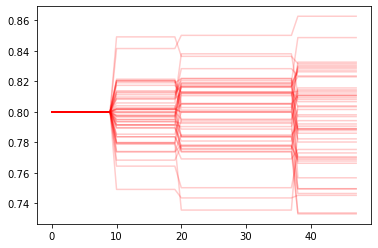

In [4]:
for k in results.keys():
    tmp = results.get(k, forecast_timepoints=[10, 20])
    for i in range(50):
        plt.plot(tmp[:,i], '-r', alpha=0.2)
    break

# Multiregion Windpower Model

In [43]:
#wind = wind_forecast_model.simulate(timegrid, rnd)
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [44]:
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Onshore': [0.8],
                                                          'Offshore': [0.6]}
                               )

IndexError: list index out of range

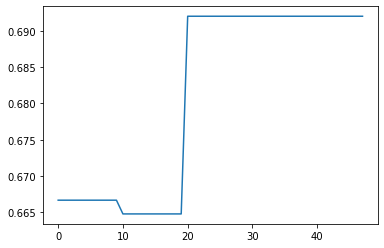

In [7]:
tmp = results.get('Wind_Germany:1', forecast_timepoints=[10, 20])
plt.plot(tmp[:,0]);

# Residual Demand Forward Model

In [45]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [46]:
rnd = np.random.normal(size=rd_model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))

In [47]:
rdm_result = rd_model.simulate(timegrid, rnd, expiries=forward_expiries, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]})

In [11]:
rdm_result.get('Power_Germany:0', forecast_timepoints=[0,1,2])

array([[0.26666667, 0.26666667, 0.26666667, ..., 0.26666667, 0.26666667,
        0.26666667],
       [0.26021478, 0.27070423, 0.26975393, ..., 0.26509957, 0.26823855,
        0.26438372],
       [0.25406328, 0.27815923, 0.27138286, ..., 0.26864876, 0.26813227,
        0.27003154],
       ...,
       [0.28389246, 0.29749926, 0.24491791, ..., 0.28798642, 0.24734741,
        0.23657972],
       [0.28392222, 0.29742968, 0.24492363, ..., 0.28800452, 0.24734926,
        0.23654951],
       [0.28392685, 0.29743316, 0.24492425, ..., 0.28804524, 0.24733697,
        0.23655771]])

In [12]:
rd_model.udls()

{'Offshore', 'Onshore', 'Power_Germany', 'Wind_Germany'}

# PPA Hedging

In [50]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)
highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [49]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [54]:
pricing_results = price_new(val_date, spec, rd_model, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]},
        forecast_hours=[6, 10, 14, 18],
          depth=3, nb_neurons=32, n_sims=10_000, regularization=0.0,
          epochs=100, verbose=1, tensorboard_logdir = None, initial_lr=1e-3, 
          batch_size=100, decay_rate=0.8, seed=42)

Epoch 1/100
100/100 [==============================] - 5s 2ms/step - loss: 2.5951e-05
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 2.2087e-06
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7289e-06
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 1.5864e-06
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6199e-06
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6879e-06
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7643e-06
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7009e-06
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7416e-06
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7037e-06
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6285e-06
Epoch 12/100
100/100 [==============================

100/100 [==============================] - 0s 2ms/step - loss: 1.5711e-06
Epoch 96/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6086e-06
Epoch 97/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7011e-06
Epoch 98/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6424e-06
Epoch 99/100
100/100 [==============================] - 0s 2ms/step - loss: 1.5433e-06
Epoch 100/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6029e-06


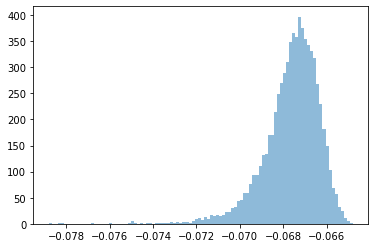

In [56]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.hist(pnl,bins=100, alpha=0.5, density=True);


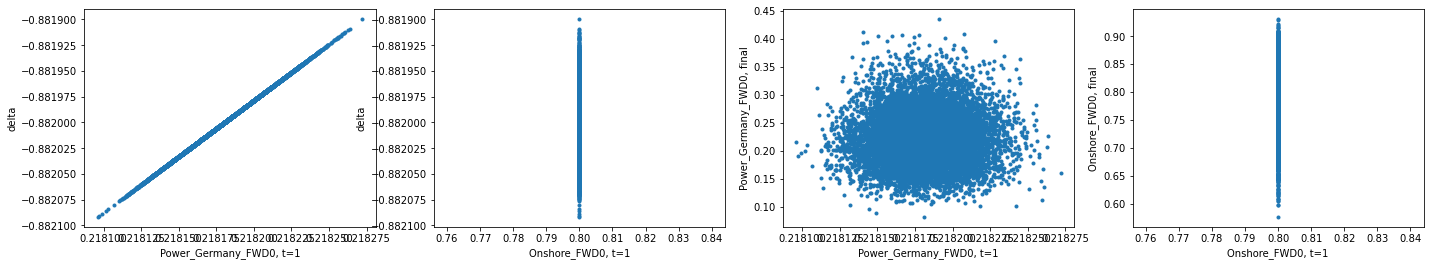

In [79]:
t = 1
n_x = 1
n_y = 4
plt.figure(figsize=(24,4))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1

In [78]:
delta

array([[-0.8819939],
       [-0.8819939],
       [-0.8819939],
       ...,
       [-0.8819939],
       [-0.8819939],
       [-0.8819939]], dtype=float32)